# Exploring the reference database
Let's see what properties we can find :) <br>
Let's put more data into it !

## TODOs
 - scale frequency spectrum before
 - species level precision (instead of strand level)
 - automate all : 
  - PCA/LDA/Autoencoder/nothing
  - number of bacteria and samples
 - treat plasmids differently
 - try with real Nanopore reads
 - unsupervised learning on all windows into 10 bins ?
 - hierarchical clustering ??
 - clustering with minimal distance
 - taxo id to family or genus
 - tsne plot
 - Add **Visualisation** : https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html
 - Save each case, not each run. don't run cases that have already been computed.

## Structure
In `genome/`, there's multiple sub-folder, we will start with `Bacteria`
It then contains all recorded species/strands in individual folders


http://defindit.com/readme_files/ncbi_file_extension_format.html

What we need is the taxo id, name, and the DNA, which can be found in:
 - .gbk for the taxo and name
 - .fna for the sequence

## Coding
### Import and Paths

In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import traceback
from datetime import datetime as dt
from time import time
from tqdm import tqdm_notebook as tqdm

In [2]:
from sklearn.preprocessing import MinMaxScaler, scale
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

In [3]:
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNet
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
plt.rcParams['figure.figsize'] = 13, 8

In [5]:
pd.options.display.float_format = '{:,.2f}'.format

In [6]:
path_ref_db = "/mnt/genomeDB/ncbi/genomes/Bacteria/"
path_kmer_freq = "/home/sjriondet/Data/Kmer_frequencies/"

In [7]:
path_4mer = "4_V4_10k/"
path_4mer = os.path.join(path_kmer_freq, path_4mer)

In [8]:
path_all = os.path.join(path_4mer, "_all_bacteria_4mers.largepd")
path_all

'/home/sjriondet/Data/Kmer_frequencies/4_V4_10k/_all_bacteria_4mers.largepd'

## Main dataset

Load the whole dataset. Will take a while !!

In [9]:
all_all_df = pd.read_pickle(path_all)

In [10]:
cols_kmers = all_all_df.columns.to_list()[4:]

In [11]:
cols_spe = sorted(list(set(all_all_df.columns.to_list()).difference(set(cols_kmers))))

In [12]:
for col in cols_kmers:
    all_all_df[col] = all_all_df[col].astype('float64')

In [13]:
all_all_df.sample(5)

,bacteria,fna,len_genome,start,AAAA,AAAC,AAAG,AAAT,AACA,AACC,...,TTCG,TTCT,TTGA,TTGC,TTGG,TTGT,TTTA,TTTC,TTTG,TTTT
181,Geobacillus_JF8_uid215234,NC_022080,3446630,1810000,97.00,71.00,49.00,93.00,67.00,43.00,...,39.00,69.00,56.00,65.00,38.00,68.00,72.00,114.00,93.00,172.00
266,Desulfosporosinus_meridiei_DSM_13257_uid75097,NC_018515,4873567,2660000,41.00,45.00,56.00,50.00,58.00,45.00,...,33.00,87.00,54.00,52.00,44.00,42.00,79.00,85.00,62.00,111.00
65,Lactobacillus_amylovorus_GRL1118_uid160233,NC_017470,1894401,650000,175.00,56.00,98.00,101.00,44.00,35.00,...,25.00,47.00,112.00,64.00,60.00,47.00,106.00,60.00,108.00,142.00
355,Clostridium_phytofermentans_ISDg_uid58519,NC_010001,4847594,3550000,117.00,65.00,58.00,94.00,72.00,33.00,...,35.00,113.00,53.00,41.00,39.00,45.00,123.00,94.00,71.00,196.00
46,Polynucleobacter_necessarius_STIR1_uid58967,NC_010531,1560469,460000,90.00,34.00,67.00,62.00,22.00,27.00,...,41.00,48.00,76.00,92.00,95.00,52.00,86.00,49.00,102.00,92.00


In [14]:
all_all_df.shape

(953798, 260)

In [15]:
unique_bacteria = len(all_all_df.bacteria.unique())
unique_bacteria

2782

In [16]:
all_df = all_all_df[all_all_df.bacteria.isin(all_all_df.bacteria.unique()[:100])].sample(10000)

## Reduction possibilities

### PCA Principal Component Analysis
Reducing dimension from 256 to ~10

In [17]:
components = 50

In [18]:
pca = PCA(n_components=components)
pca.fit(all_df[cols_kmers])

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

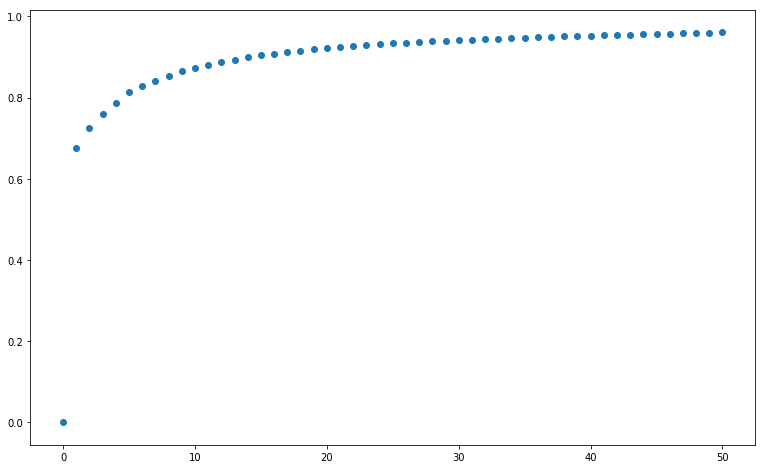

captured by PCA: 96.1%


In [19]:
plt.scatter(x=range(len(pca.explained_variance_ratio_)+1), 
            y=np.insert(pca.explained_variance_ratio_.cumsum(), 0, 0))
plt.show()
print(f"captured by PCA: {sum(pca.explained_variance_ratio_)*100:0.1f}%")

In [20]:
cols_pca = [f"pca_{i+1}" for i in range(components)]

In [21]:
np_pca = pca.transform(all_df[cols_kmers])
df_pca = pd.DataFrame(np_pca, columns=cols_pca)
df_pca = pd.concat([all_df[cols_spe].reset_index(inplace=False, drop=True), df_pca], axis=1) # , ignore_index=True)
df_pca["color_map"] = 0
for i, bacteria in enumerate(df_pca.bacteria.unique()):
    df_pca.loc[df_pca["bacteria"] == bacteria, ['color_map']] = i
df_pca.shape

(10000, 55)

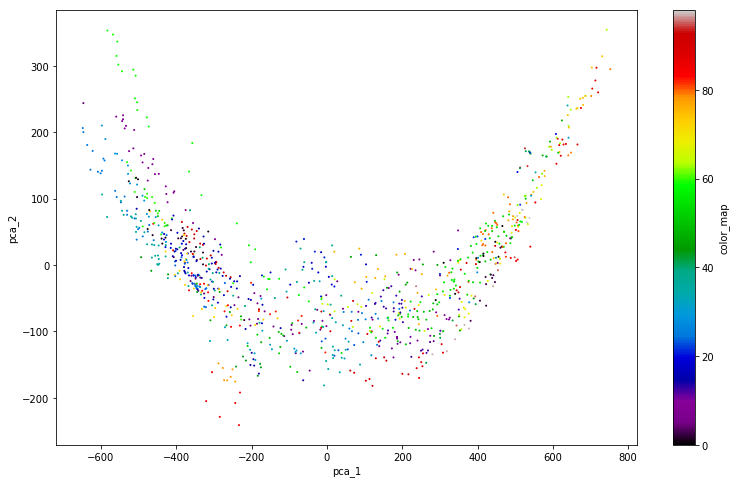

captured by PCA: 72.6%


In [22]:
df_pca.sample(1000).plot.scatter(x="pca_1", y="pca_2", s=1, c="color_map", colormap="nipy_spectral")  # gist_ncar
plt.show()
print(f"captured by PCA: {sum(pca.explained_variance_ratio_[:2])*100:0.1f}%")

### LDA Linear Discriminant Analysis
Another dimension reduction

In [23]:
lda = LinearDiscriminantAnalysis(n_components=components)
lda.fit(all_df[cols_kmers], all_df.bacteria)
print(f"captured by LDA: {sum(lda.explained_variance_ratio_)*100:0.1f}%")

captured by LDA: 98.2%


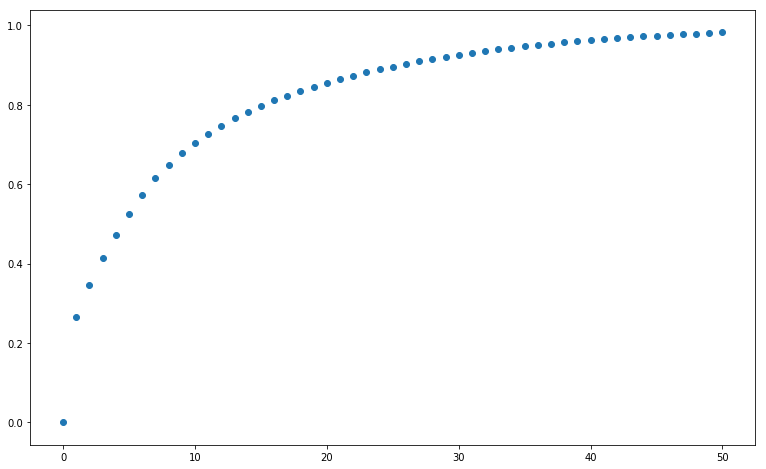

captured by LDA: 98.2%


In [24]:
plt.scatter(x=range(len(lda.explained_variance_ratio_)+1), 
            y=np.insert(lda.explained_variance_ratio_.cumsum(), 0, 0),)
plt.show()
print(f"captured by LDA: {sum(lda.explained_variance_ratio_)*100:0.1f}%")

In [25]:
lda = LinearDiscriminantAnalysis(n_components=components)
lda.fit(all_df[cols_kmers], all_df.bacteria)
print(f"captured by LDA: {sum(lda.explained_variance_ratio_)*100:0.1f}%")

captured by LDA: 98.2%


In [26]:
np_lda = lda.transform(all_df[cols_kmers])
cols_lda = [f"lda_{i+1}" for i in range(components)]
df_lda = pd.DataFrame(np_lda, columns=cols_lda)
df_lda = pd.concat([all_df[cols_spe].reset_index(inplace=False, drop=True), df_lda], axis=1) # , ignore_index=True)
df_lda["color_map"] = 0
for i, bacteria in enumerate(df_lda.bacteria.unique()):
    df_lda.loc[df_lda["bacteria"] == bacteria, ['color_map']] = i

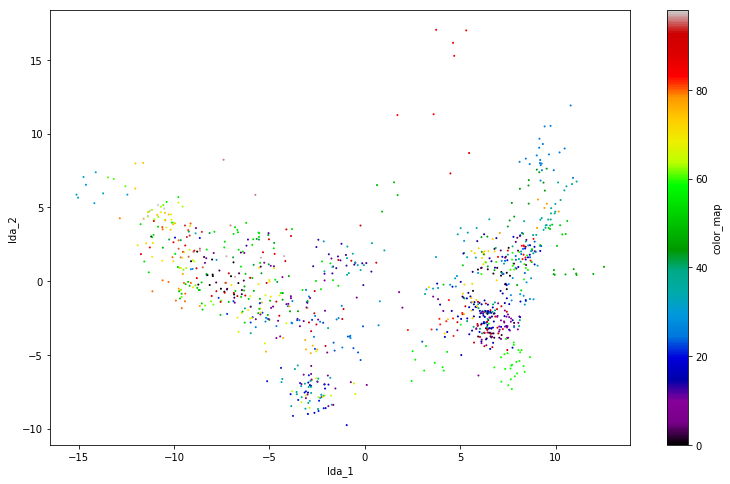

captured by LDA: 34.7%


In [27]:
df_lda.sample(1000).plot.scatter(x="lda_1", y="lda_2", s=1, c="color_map", colormap="nipy_spectral")  # gist_ncar
plt.show()
print(f"captured by LDA: {sum(lda.explained_variance_ratio_[:2])*100:0.1f}%")

## Functions

In [28]:
def apply_PCA(x, y, components=10):
    cols_pca = [f"pca_{i+1}" for i in range(components)]
    pca = PCA(n_components=components)
    np_pca = pca.fit_transform(x)
    df_pca = pd.DataFrame(np_pca, columns=cols_pca, index=x.index)
    return df_pca, y, sum(pca.explained_variance_ratio_)

In [29]:
def apply_LDA(x, y, components=10):
    cols_lda = [f"lda_{i+1}" for i in range(components)]
    lda = LinearDiscriminantAnalysis(n_components=components)
    np_lda = lda.fit_transform(x, y)
    print(np_lda.shape)
    df_lda = pd.DataFrame(np_lda, columns=cols_lda, index=x.index)
    return df_lda, y, sum(lda.explained_variance_ratio_)

In [30]:
def apply_nothing(x, y, components=None):
    return x, y, 1

In [31]:
dim_reduc = {
    "PCA": apply_PCA,
    "LDA": apply_LDA,
    "raw": apply_nothing,
}

In [32]:
def save_models(path_models, name_run, models):
    for model in tqdm(models_names):
        with open(os.path.join(path_models, f"_{name_run}_{model}.pkl"), 'wb') as f_out:
            pickle.dump(models[model], f_out)

In [33]:
def launch_models(models_names, X_train, y_train, X_test, y_test=None, predict=True, path_models="", name_run=""):
    models = {
        "QDA": QuadraticDiscriminantAnalysis(),
        "Naive_Bayes": GaussianNB(),
        "RF": RandomForestClassifier(max_depth=20, random_state=0, n_estimators=100, n_jobs=6),
        "SVM_lin": SVC(kernel="linear", C=0.025),
        "SVM_rbf": SVC(kernel='rbf', C=1, gamma='auto', cache_size=1000),   # too slow and memory consumption
        "KNeigh": KNeighborsClassifier(n_neighbors=20, n_jobs=6),
        "DTree": DecisionTreeClassifier(max_depth=20),
        "NNet": MLPClassifier(alpha=1),    # too slow
        "AdaBoost": AdaBoostClassifier(),  # worse classifier
    }
    results = {}
    for name in tqdm(models_names, disable=False, desc="ML_Models", leave=False, dynamic_ncols=True):
        if name in models.keys():
#             print(name)
            start = time()
            results[name] = {}

            # Train
            models[name].fit(X_train, y_train)
            time_fitted = time()
            results[name]["time_fit"] = time_fitted - start

            if predict:
                # Predict
                predicted = models[name].predict(X_test)
                results[name]["predicted"] = predicted
                time_predicted = time()
                results[name]["time_predict"] = time_predicted - time_fitted

            results[name]["time"] = time() - start
            
    if path_models != "" and name_run != "": save_models(path_models, name_run, models)
    return results

In [34]:
def pred_accuracy(results, y_test):
    to_df = {"Ground_Truth": y_test}
    for name in results.keys():
        predicted = results[name]["predicted"]
        to_df[f"{name}_pred"] = predicted
        to_df[f"{name}_strand"] = (y_test==predicted).astype(int)
        to_df[f"{name}_species"] = 0
        to_df[f"{name}_genus"] = 0
    pd_res = pd.DataFrame(to_df)

    for name in results.keys():
        # check if the first split of the species name is egal (corresponds to genus level)
        pd_res[f"{name}_genus"] = (pd_res.Ground_Truth.str.split("_", 1).str[0] == \
                                         pd_res[f"{name}_pred"].str.split("_", 1).str[0]).astype(int)
        # Then chec the second, and multiply by the genus (in case some second names are common accross genus)
        pd_res[f"{name}_species"] = ((pd_res.Ground_Truth.str.split("_", 2).str[1] == \
                                            pd_res[f"{name}_pred"].str.split("_", 2).str[1]) \
                                            * pd_res[f"{name}_genus"]).astype(int)
    
    return pd_res

In [35]:
def ranking_ml(pd_res, test_size, results):
    ranking = 100 * pd_res.sum(numeric_only=True) / test_size
    pd_ranking = pd.DataFrame({"name": ranking.index.values, 
                               "percentage": ranking.values})
    for times in ("time", "time_fit", "time_predict", ):
        pd_ranking[times] = 0
        for name in results.keys():
            pd_ranking.loc[pd_ranking["name"].str.contains(name), [times]] = results[name][times]
    return pd_ranking.sort_values(by=["percentage"], ascending=False)

# Pipeline

In [51]:
def run_all_param(df_initial, ml_models, path_4mer=path_4mer, path_models="ml_models/", n_samples=10000, n_bacteria=100,
                  dim_reduc_tool="LDA", components=10, test_ratio=0.1, random_seed=0,):
    
    path_models = os.path.join(path_4mer, path_models)
    if n_bacteria < 0:
        n_bacteria = len(df_initial.bacteria.unique())
        df_down_sampled = df_initial
    else:
        df_down_sampled = df_initial[df_initial.bacteria.isin(df_initial.bacteria.unique()[:n_bacteria])]
    
    if n_samples < 0:
        n_samples = df_down_sampled.shape[0]
    df_down_sampled = df_down_sampled.sample(n_samples, random_state=random_seed)
    test_size = test_ratio * n_samples

    name_run = f"_{dim_reduc_tool}-{'256' if dim_reduc_tool=='raw' else components}" \
               f"_{df_down_sampled.shape[0] if n_samples<0 else n_samples}-samples" \
               f"_{unique_bacteria if n_bacteria<0 else n_bacteria}-bac"
    print(f"\n\n{name_run}")

    y = df_down_sampled["bacteria"]
    x = df_down_sampled[cols_kmers]

    # average each row ?

    x, y, variance_captured = dim_reduc[dim_reduc_tool](x, y, components)
    print(f"Variance captured by {dim_reduc_tool} = {variance_captured*100:.2f}%")

    x = pd.DataFrame(scale(x), index=x.index, columns=x.columns)

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=random_seed)

    results = {}
    try:
        results = launch_models(ml_models, X_train, y_train, X_test, y_test, path_models, )  # name_run
    except Exception as e:
        print("type error: " + str(e))
        print(traceback.format_exc())
        return name_run, results, y_test, variance_captured
        
    pd_res = pred_accuracy(results, y_test)
    pd_res.to_pickle(os.path.join(path_models, f"_{name_run}_results.pd"))

    pd_ranking = ranking_ml(pd_res, test_size, results)
    pd_ranking.to_pickle(os.path.join(path_models, f"_{name_run}_ranking.pd"))
    return name_run, pd_ranking, pd_res, variance_captured

In [52]:
def launch_multiple_cases():
    all_ranking = {}
    all_results = {}
    all_dim_reduc = {}
    guard = 0
    stop = 80

    for n_s in tqdm(sample_sizes, desc="#Sample", dynamic_ncols=True):  # 10000,
        for n_b in tqdm(bacteria_number, desc="#Bacteria", dynamic_ncols=True, leave=False):
            for dim_r in tqdm(dimension_reductions, desc="DimReduc", dynamic_ncols=True, leave=False):  # "raw", 

                # Some combination are not worth or too slow, skip them
                if n_s == 10000 and (n_b <= 0 or 500 < n_b):                 continue
                if dim_r == "raw" and n_s == -1 and (n_b <= 0 or 200 < n_b): continue

                name, pd_ranking, pd_res, variance_captured = \
                    run_all_param(all_all_df, ml_models, n_samples=n_s, n_bacteria=n_b, 
                                  dim_reduc_tool=dim_r, components=20, random_seed=7)

                if not isinstance(pd_ranking, dict): print(pd_ranking[:10])
                all_ranking[name] = pd_ranking
                all_results[name] = pd_res
                all_dim_reduc[name] = variance_captured
                print(pd_ranking[["time_fit", "time_predict"]].describe().loc[["mean"]])

                guard += 1
                if guard>stop: break
            if guard>stop: break
        if guard>stop: break

    path_models = os.path.join(path_4mer, "ml_models/")
    now = dt.now().strftime("%Y-%m-%d_%H-%M")
    with open(os.path.join(path_models, f"_all_results_{now}.pkl"), 'wb') as f: pickle.dump(all_results, f)
    with open(os.path.join(path_models, f"_all_rankings_{now}.pkl"), 'wb') as f: pickle.dump(all_ranking, f)
    print("Finished !")

In [46]:
print("Ready ?")

Ready ?


In [59]:
# Parameters

# ml_models = ['Naive_Bayes', 'KNeigh', 'QDA', 'RF', 'SVM_lin', 'SVM_rbf', 'DTree', 'NNet']
ml_models = ['Naive_Bayes', 'KNeigh', 'QDA''RF', 'DTree', ] # 'SVM_lin', 'SVM_rbf', 'NNet', 
# ml_models = ['Naive_Bayes', 'RF', 'KNeigh', 'DTree', 'QDA'] # 'SVM_lin', 'SVM_rbf', 'NNet', 

sample_sizes = (-1, )  # 
bacteria_number = (-1, )  #  -1,
dimension_reductions = ("LDA", )  # "raw", "PCA", 

In [ ]:
launch_multiple_cases()



_LDA-20_953798-samples_2782-bac
(953798, 20)
Variance captured by LDA = 77.66%


In [58]:
launch_multiple_cases()



_LDA-20_338665-samples_1000-bac
(338665, 20)
Variance captured by LDA = 78.18%
                  name  percentage   time  time_fit  time_predict
2         KNeigh_genus       92.13  66.29      1.39         64.89
5    Naive_Bayes_genus       90.57  12.34      7.10          5.24
1       KNeigh_species       77.49  66.29      1.39         64.89
4  Naive_Bayes_species       75.14  12.34      7.10          5.24
8          DTree_genus       67.18 220.09    219.93          0.16
3   Naive_Bayes_strand       53.58  12.34      7.10          5.24
0        KNeigh_strand       52.59  66.29      1.39         64.89
7        DTree_species       52.28 220.09    219.93          0.16
6         DTree_strand       35.60 220.09    219.93          0.16
      time_fit  time_predict
mean     76.14         23.43

Finished !


In [55]:
launch_multiple_cases()



_LDA-20_34119-samples_100-bac
(34119, 20)
Variance captured by LDA = 86.03%


/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


                 name  percentage  time  time_fit  time_predict
8           QDA_genus       98.10  0.22      0.14          0.08
17      SVM_rbf_genus       98.10 18.93     10.06          8.87
14      SVM_lin_genus       97.95 12.88      4.62          8.26
11           RF_genus       97.75  6.72      6.61          0.11
5   Naive_Bayes_genus       97.45  0.18      0.13          0.05
23         NNet_genus       97.42 41.27     41.25          0.02
2        KNeigh_genus       97.34  1.47      0.07          1.40
13    SVM_lin_species       93.20 12.88      4.62          8.26
16    SVM_rbf_species       92.94 18.93     10.06          8.87
10         RF_species       91.47  6.72      6.61          0.11
      time_fit  time_predict
mean      8.24          2.35


_PCA-20_34119-samples_100-bac
Variance captured by PCA = 92.17%


/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


                 name  percentage  time  time_fit  time_predict
17      SVM_rbf_genus       97.37 26.81     16.42         10.39
14      SVM_lin_genus       96.90 16.40      6.63          9.77
8           QDA_genus       96.87  0.21      0.13          0.08
11           RF_genus       95.99  6.82      6.71          0.11
23         NNet_genus       95.87 43.75     43.73          0.02
2        KNeigh_genus       95.64  2.97      0.07          2.90
5   Naive_Bayes_genus       93.85  0.18      0.13          0.05
16    SVM_rbf_species       91.77 26.81     16.42         10.39
13    SVM_lin_species       91.65 16.40      6.63          9.77
7         QDA_species       90.68  0.21      0.13          0.08
      time_fit  time_predict
mean      9.61          2.92

Finished !


In [53]:
launch_multiple_cases()



_LDA-20_34119-samples_100-bac
(34119, 20)
Variance captured by LDA = 86.03%
                  name  percentage  time  time_fit  time_predict
5    Naive_Bayes_genus       97.45  0.18      0.12          0.05
2         KNeigh_genus       97.34  1.46      0.07          1.39
1       KNeigh_species       91.39  1.46      0.07          1.39
4  Naive_Bayes_species       91.21  0.18      0.12          0.05
8          DTree_genus       90.77  3.05      3.04          0.00
7        DTree_species       84.38  3.05      3.04          0.00
0        KNeigh_strand       80.83  1.46      0.07          1.39
3   Naive_Bayes_strand       80.48  0.18      0.12          0.05
6         DTree_strand       74.45  3.05      3.04          0.00
      time_fit  time_predict
mean      1.08          0.48


_PCA-20_34119-samples_100-bac
Variance captured by PCA = 92.17%
                  name  percentage  time  time_fit  time_predict
2         KNeigh_genus       95.61  2.17      0.08          2.10
5    Naive_Bayes_g

In [ ]:
launch_multiple_cases()



_LDA-20_338665-samples_1000-bac
(338665, 20)
Variance captured by LDA = 78.18%
                  name  percentage   time  time_fit  time_predict
2         KNeigh_genus       92.13  60.65      1.38         59.27
5    Naive_Bayes_genus       90.57  12.22      7.13          5.08
1       KNeigh_species       77.49  60.65      1.38         59.27
4  Naive_Bayes_species       75.14  12.22      7.13          5.08
8          DTree_genus       67.15 219.01    218.85          0.16
3   Naive_Bayes_strand       53.58  12.22      7.13          5.08
0        KNeigh_strand       52.59  60.65      1.38         59.27
7        DTree_species       52.23 219.01    218.85          0.16
6         DTree_strand       35.65 219.01    218.85          0.16
      time_fit  time_predict
mean     75.79         21.51


_PCA-20_338665-samples_1000-bac
Variance captured by PCA = 91.10%


In [40]:
all_ranking = {}
all_results = {}
all_dim_reduc = {}
guard = 0
stop = 80
    
for n_s in tqdm(sample_sizes, desc="#Sample", dynamic_ncols=True):  # 10000,
    for n_b in tqdm(bacteria_number, desc="#Bacteria", dynamic_ncols=True, leave=False):
        for dim_r in tqdm(dimension_reductions, desc="DimReduc", dynamic_ncols=True, leave=False):  # "raw", 
            
            # Some combination are not worth or too slow, skip them
            if n_s == 10000 and (n_b <= 0 or 500 < n_b):
                continue
            if dim_r == "raw" and n_s == -1 and (n_b <= 0 or 200 < n_b):
                continue
            
            name, pd_ranking, pd_res, variance_captured = \
                run_all_param(all_all_df, ml_models, n_samples=n_s, n_bacteria=n_b, 
                              dim_reduc_tool=dim_r, components=20, random_seed=7)
            
            if not isinstance(pd_ranking, dict): print(pd_ranking[:8])
            all_ranking[name] = pd_ranking
            all_results[name] = pd_res
            all_dim_reduc[name] = variance_captured
            print(pd_ranking[["time_fit", "time_predict"]].describe().loc[["mean"]])
            
            guard += 1
            if guard>stop:
                break
        if guard>stop:
            break
    if guard>stop:
        break



_LDA-20_97924-samples_300-bac
(97924, 20)
Variance captured by LDA = 80.15%


/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


                 name  percentage   time  time_fit  time_predict
17          QDA_genus       94.86   1.19      0.50          0.69
8        KNeigh_genus       94.09  11.46      0.29         11.17
2            RF_genus       93.73  48.54     47.62          0.92
14  Naive_Bayes_genus       92.71   1.17      0.74          0.43
5          NNet_genus       92.01 643.30    643.17          0.12
16        QDA_species       85.44   1.19      0.50          0.69
1          RF_species       84.64  48.54     47.62          0.92
7      KNeigh_species       84.26  11.46      0.29         11.17
      time_fit  time_predict
mean    118.87          2.22



save results

In [43]:
path_models = os.path.join(path_4mer, "ml_models/")
now = dt.now().strftime("%Y-%m-%d_%H-%M")
with open(os.path.join(path_models, f"_all_results_{now}.pkl"), 'wb') as f:
    pickle.dump(all_results, f)
with open(os.path.join(path_models, f"_all_rankings_{now}.pkl"), 'wb') as f:
    pickle.dump(all_ranking, f)

In [44]:
print(pd_ranking[["time_fit", "time_predict"]].mean())

time_fit       2.08
time_predict   3.14
dtype: float64


In [53]:
pd_ranking[["time_fit", "time_predict"]].describe().loc[["mean"]]

,time_fit,time_predict
mean,2.08,3.14


In [51]:
path_models

'/home/sjriondet/Data/Kmer_frequencies/4_V4_10k/ml_models/'

In [54]:
len(all_ranking)

3

In [61]:
all_all_df[all_all_df.bacteria == "Anaplasma_phagocytophilum_JM_uid213223"]

,bacteria,fna,len_genome,start,AAAA,AAAC,AAAG,AAAT,AACA,AACC,...,TTCG,TTCT,TTGA,TTGC,TTGG,TTGT,TTTA,TTTC,TTTG,TTTT
0,Anaplasma_phagocytophilum_JM_uid213223,NC_021880,1481598,0,137.00,33.00,79.00,82.00,44.00,16.00,...,25.00,58.00,63.00,48.00,63.00,56.00,75.00,64.00,77.00,134.00
1,Anaplasma_phagocytophilum_JM_uid213223,NC_021880,1481598,10000,170.00,68.00,99.00,103.00,73.00,25.00,...,19.00,70.00,67.00,41.00,35.00,45.00,70.00,36.00,60.00,88.00
2,Anaplasma_phagocytophilum_JM_uid213223,NC_021880,1481598,20000,61.00,40.00,61.00,56.00,53.00,31.00,...,24.00,85.00,49.00,46.00,41.00,77.00,72.00,86.00,72.00,156.00
3,Anaplasma_phagocytophilum_JM_uid213223,NC_021880,1481598,30000,95.00,58.00,51.00,77.00,44.00,40.00,...,24.00,46.00,52.00,53.00,28.00,66.00,58.00,48.00,54.00,88.00
4,Anaplasma_phagocytophilum_JM_uid213223,NC_021880,1481598,40000,64.00,31.00,62.00,47.00,59.00,27.00,...,18.00,61.00,61.00,58.00,58.00,72.00,63.00,55.00,84.00,100.00
5,Anaplasma_phagocytophilum_JM_uid213223,NC_021880,1481598,50000,88.00,28.00,56.00,71.00,31.00,16.00,...,26.00,91.00,56.00,55.00,56.00,75.00,71.00,83.00,84.00,126.00
6,Anaplasma_phagocytophilum_JM_uid213223,NC_021880,1481598,60000,103.00,59.00,73.00,62.00,52.00,39.00,...,27.00,79.00,48.00,43.00,35.00,61.00,52.00,56.00,66.00,86.00
7,Anaplasma_phagocytophilum_JM_uid213223,NC_021880,1481598,70000,78.00,40.00,80.00,53.00,36.00,17.00,...,28.00,48.00,71.00,52.00,46.00,73.00,65.00,45.00,89.00,151.00
8,Anaplasma_phagocytophilum_JM_uid213223,NC_021880,1481598,80000,88.00,54.00,65.00,75.00,54.00,37.00,...,21.00,58.00,51.00,40.00,37.00,70.00,61.00,56.00,60.00,83.00
9,Anaplasma_phagocytophilum_JM_uid213223,NC_021880,1481598,90000,48.00,41.00,39.00,52.00,41.00,39.00,...,12.00,69.00,52.00,44.00,40.00,60.00,66.00,62.00,65.00,97.00


In [ ]:
all_results["_nothing-20_10000-samples_100-bac"][0]

In [ ]:
len(all_results.keys())

In [ ]:
for key in all_results.keys():
    print(key)
    print(all_results[key][0])



### End of the script.
Sylvain @GIS

In [ ]:
ranking_ml(pd_res, 1000)

In [ ]:
pd_res

In [ ]:
pd_res[f"RF_pred"].str.split("_", 2).str[1]

In [ ]:
pd_res.Ground_Truth.str.split("_", 1).str[0] == pd_res[f"RF_pred"].str.split("_", 1).str[0]

In [ ]:
pd_res.Ground_Truth == pd_res[f"RF_pred"]

In [ ]:
path_models = "ml_models/"
path_models = os.path.join(path_4mer, path_models)

In [ ]:
n_samples = 10000
n_bacteria = 100
random_seed = 0
dim_reduc_tool = "PCA"
components = 10
test_ratio = 0.1

In [ ]:
name_run = f"_{dim_reduc_tool}-{components}_{n_samples}-samples_{n_bacteria}-bac"

In [ ]:
all_df = all_all_df[all_all_df.bacteria.isin(all_all_df.bacteria.unique()[:n_bacteria])].sample(n_samples)

In [ ]:
y = all_df["bacteria"]
x = all_df[cols_kmers]

In [ ]:
# average each row ?

In [ ]:
x, y = dim_reduc[dim_reduc_tool](x, y, components)

In [ ]:
x = pd.DataFrame(scale(x), index=x.index, columns=x.columns)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=random_seed)

In [ ]:
models_names = ['RF', 'SVM_lin', 'SVM_rbf', 'KNeigh', 'DTree', 'NNet', 'Naive_Bayes', 'QDA']

In [ ]:
results = launch_models(models_names, X_train, y_train, X_test, y_test, path_models, )  # name_run

In [ ]:
pd_res = pred_accuracy(results, y_test)
pd_res.to_pickle(os.path.join(path_models, f"_results_{name_run}.pd"))

In [ ]:
pd_res.shape

In [ ]:
pd_ranking = ranking_ml(pd_res, test_ratio * n_samples)
pd_ranking.to_pickle(os.path.join(path_models, f"_ranking_{name_run}.pd"))
pd_ranking

In [ ]:
class subSample:
    """ Attempt to use Pipeline correctly
        Select a subset of the available bacteria, and subsample again a number of windows
    """
    
    def __init__(self, n_samples=10000, n_species=100, random_state=0):
        self.n_samples = n_samples
        self.n_species = n_species
        self.random_state = random_state
        self._queried = None
        
    def fit(self, X, y):
        assert len(X) > self.n_samples, f"Dataset has less rows ({len(X)}) than the requested number of samples"
        assert len(y.unique()) > self.n_species, f"Dataset has less number of species "\
                                                 f"({len(y.unique())}) than the requested number of samples"
        if self.n_species < 0:
            self._queried = y.index
        else:
            self._queried = y[y.values.isin(y.unique()[:self.n_species])].index
        return self
    
    def transform(self, X, y=None):
        if y is None:
            if self.n_samples < 0:
                return X.iloc[self._queried]
            return X.iloc[self._queried].sample(self.n_samples, random_state=self.random_state)
        else:
            if self.n_samples < 0:
                return (X.iloc[self._queried],
                        y.iloc[self._queried]
                       )
            return (X.iloc[self._queried].sample(self.n_samples, random_state=self.random_state),
                    y.iloc[self._queried].sample(self.n_samples, random_state=self.random_state))
        
        return 
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X, y)

In [ ]:
subSam = subSample()

In [ ]:
subSam.fit(all_all_df[cols_kmers], all_all_df["bacteria"])

In [ ]:
X, y = subSam.fit_transform(all_all_df[cols_kmers], all_all_df["bacteria"])

In [ ]:
res[0].shape

In [ ]:
n_samples = 10000
n_bacteria = 100

In [ ]:
all_df = all_all_df[all_all_df.bacteria.isin(all_all_df.bacteria.unique()[:n_bacteria])].sample(n_samples)

In [ ]:
all_all_df.shape, all_df.shape

In [ ]:
# Raw data
X_train, X_test, y_train, y_test = train_test_split(scale(all_df[cols_kmers]), all_df.bacteria, 
                                                    test_size=0.1, random_state=0)

In [ ]:
y_test = all_all_df["bacteria"]

In [ ]:
queried = y_test[y_test.values.isin(y_test.unique()[:n_bacteria])].index

In [ ]:
all_all_df.iloc[queried].sample(5).shape

## Machine Learning classification

In [ ]:
cols_spe

In [ ]:
# With LDA
X_train, X_test, y_train, y_test = train_test_split(scale(df_lda[cols_pca]), df_lda.bacteria, 
                                                    test_size=0.1, random_state=0)

In [ ]:
models = {
    "RF": RandomForestClassifier(max_depth=20, random_state=0, n_estimators=100, n_jobs=6),
    "SVM_lin": SVC(kernel="linear", C=0.025),
    "SVM_rbf": SVC(kernel='rbf', C=1, gamma='auto', cache_size=1000),
    "KNeigh": KNeighborsClassifier(n_neighbors=20, n_jobs=6),
    "DTree": DecisionTreeClassifier(max_depth=20),
    "NNet": MLPClassifier(alpha=1),
#     "AdaBoost": AdaBoostClassifier(),  # worse classifier
    "Naive_Bayes": GaussianNB(),
    "QDA": QuadraticDiscriminantAnalysis()
}

In [ ]:
results = {}

In [ ]:
for name in tqdm(models.keys()):
    if name not in results.keys():
        print(name)
        start = time()
        results[name] = {}
        
        models[name].fit(X_train, y_train)
        time_fitted = time()
        results[name]["time_fit"] = time_fitted - start
        
        predicted = models[name].predict(X_test)
        results[name]["predicted"] = predicted
        time_predicted = time()
        results[name]["time_predict"] = time_predicted - time_fitted
        
#         score = models[name].score(X_test, y_test)
#         results[name]["score"] = score
#         results[name]["time_score"] = time() - time_predicted
        
        results[name]["time"] = time() - start
    

In [ ]:
path_models = "ml_models/"
path_models = os.path.join(path_4mer, path_models)

In [ ]:
name_run = f"_LDA40_{n_samples}samples_{n_bacteria}bac"

`name_run = f"_LDA-40_{n_samples}-samples_{n_bacteria}-bac"`

In [ ]:
if True:
    for model in tqdm(models.keys()):
        with open(os.path.join(path_models, f"_{model}_{name_run}.pkl"), 'wb') as f_out:
            pickle.dump(models[model], f_out)

In [ ]:
to_df = {"Ground_Truth": y_test}
for name in results.keys():
    predicted = results[name]["predicted"]
    to_df[f"{name}"] = (y_test==predicted).astype(int)
    to_df[f"{name}_pred"] = predicted
pd_res = pd.DataFrame(to_df)

pd_res.to_pickle(os.path.join(path_models, f"_results_{name_run}.pd"))

In [ ]:
ranking = 100 * pd_res.sum(numeric_only=True) / pd_res.RF.count()

In [ ]:
pd_ranking = pd.DataFrame({"name": ranking.index.values, 
                           "percentage": ranking.values})

In [ ]:
for times in ("time", "time_fit", "time_predict", ):
    pd_ranking[times] = 0
    for name in results.keys():
        pd_ranking.loc[pd_ranking["name"] == name, [times]] = results[name][times]

In [ ]:
pd_ranking = pd_ranking.sort_values(by=["percentage"], ascending=False)
pd_ranking

## Saved results for various input settings

Results for 100,000 samples from 100 species, NO PCA, 256 features

In [ ]:
pd_ranking = pd_ranking.sort_values(by=["percentage"], ascending=False)
pd_ranking.to_pickle(os.path.join(path_models, f"_ranking_{name_run}.pd"))
pd_ranking

Results for 100,000 samples from 100 species, LDA, 40 features

In [ ]:
pd_ranking = pd_ranking.sort_values(by=["percentage"], ascending=False)
pd_ranking.to_pickle(os.path.join(path_models, f"_ranking_{name_run}.pd"))
pd_ranking

Results for 100,000 samples from 100 species, LDA, 10 features

In [ ]:
pd_ranking = pd_ranking.sort_values(by=["percentage"], ascending=False)
pd_ranking.to_pickle(os.path.join(path_models, f"_ranking_{name_run}.pd"))
pd_ranking

Results for 100,000 samples from 100 species, with PCA, 10 features

In [ ]:
pd_ranking.sort_values(by=["percentage"], ascending=False)

Results for 10,000 samples from 100 species, with PCA

In [ ]:
pd_ranking.sort_values(by=["percentage"], ascending=False)

In [ ]:
pd_res

In [ ]:
all_df.sample(5)

In [ ]:
all_df[all_df.fna.str.contains("NC")].shape

In [ ]:
all_df.loc[all_df.bacteria.str.contains("Salmonella_enterica_serovar_Bovismorbificans_3"), "fna"].unique()

In [ ]:
all_df[(all_df.bacteria.str.contains("Salmonella_enterica_serovar_Bovismorbificans_3"))].len_genome.unique()

In [ ]:
y_test

In [ ]:
df_pca1000.bacteria



### End of the script.
Sylvain @GIS

## Keep other methods

ML stuff

https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [ ]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [ ]:
def normalise_counts(kmer_count):
    """Nested dict, normalize each of the sub dict. """
    for window in kmer_count.keys():
        max_val = max(kmer_count[window].values())
        for key in kmer_count[window]:
            kmer_count[window][key] /= max_val